In [ ]:
!pip install keras-tuner

COVID-19 detection

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Embedding, Activation, AveragePooling2D, GlobalAveragePooling2D, Input, Conv1D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from keras.callbacks import EarlyStopping
from keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.optimizers import SGD, Nadam, Adam
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.layers import GlobalMaxPooling2D
from kerastuner.tuners import Hyperband
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from keras.models import save_model
from google.colab import files
import itertools  
import os

In [ ]:
import zipfile
# Download the dataset from google drive because from kaggle the download failed by error 404 
# Kaggle: https://www.kaggle.com/mohammadrahimzadeh/covidctset-a-large-covid19-ct-scans-dataset
# we have it downloaded, if it doesnt start, ask for help
!gdown --id 1N0jmtIJkzRrPJHpXpk8mlM5JPirL6_Gb --output /tmp/train_valid.zip
local_zip = '/tmp/train_valid.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp/train_valid')
zip_ref.close()

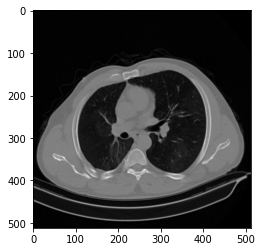

In [ ]:
# show an image of the dataset
import matplotlib.pyplot as plt
path='/tmp/train_valid/137covid_patient100_SR_2_IM00029.tif'
img = plt.imread(path)
plt.imshow(img, cmap="gray")
plt.show()

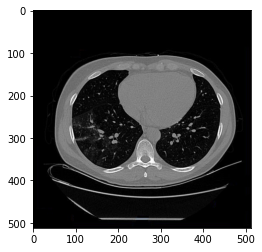

In [ ]:
# showing the image we want to predict with the model
path = '/content/5TUDO.tif'
img = plt.imread(path)
plt.imshow(img, cmap="gray")
plt.show()

In [ ]:
print(img.shape)

(512, 512, 3)


In [ ]:
# get the filenames of the pictures
source = os.path.join("/tmp", "train_valid")
set_filenames = os.listdir(source)

In [ ]:
# create 2 array, one with the covid pictures, one with the normals
covid_fnames = []
normal_fnames = []
for f in set_filenames:
  if "normal" in f:
    normal_fnames.append(f)
  else:
    covid_fnames.append(f)

In [ ]:
# create the test, valid, train arrays
from random import shuffle
train_size = 1500
test_size = 391


shuffle(covid_fnames)
shuffle(normal_fnames)
train_X = covid_fnames[:train_size]
test_X = covid_fnames[train_size:train_size+test_size]
valid_X = covid_fnames[train_size+test_size:]
train_X.extend(normal_fnames[:train_size])
valid_X.extend(normal_fnames[train_size:train_size+test_size+10])
test_X.extend(normal_fnames[train_size+test_size+10:])

In [ ]:
# create directories for the dataimagegenerator
train_covid = os.path.join("/tmp", "train/covid")
train_normal = os.path.join("/tmp", "train/normal")
valid_covid = os.path.join("/tmp", "valid/covid")
valid_normal = os.path.join("/tmp", "valid/normal")
test_covid = os.path.join("/tmp", "test/covid")
test_normal = os.path.join("/tmp", "test/normal")
source = os.path.join("/tmp", "train_valid")

import shutil
os.makedirs(train_covid)
os.makedirs(train_normal)
os.makedirs(valid_covid)
os.makedirs(valid_normal)
os.makedirs(test_covid)
os.makedirs(test_normal)

In [ ]:
# moving the images to their directory
images = os.listdir(source)
for im in images:
  if  im in train_X:
    if "covid" in im:
      shutil.move(os.path.join(source, im), train_covid)
    elif "normal" in im:
      shutil.move(os.path.join(source, im), train_normal)
  elif im in valid_X:
    if "covid" in im:
      shutil.move(os.path.join(source, im), valid_covid)
    elif "normal" in im:
      shutil.move(os.path.join(source, im), valid_normal)
  elif im in test_X:
    if "covid" in im:
      shutil.move(os.path.join(source, im), test_covid)
    elif "normal" in im:
      shutil.move(os.path.join(source, im), test_normal)


In [ ]:
#getting the train/test/valid directories
train_dir = os.path.join("/tmp/train")
test_dir = os.path.join("/tmp/test")
valid_dir = os.path.join("/tmp/valid")

In [ ]:
# using batch size 32 and image size 300 for the images wit grayscale
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_size = 300
batch_size = 32

#creating ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.05)
test_datagen = ImageDataGenerator(rescale=1./255)

#prepocessing images
train_generator = train_datagen.flow_from_directory(train_dir ,target_size=(img_size,img_size),batch_size=batch_size, class_mode='binary', color_mode="grayscale")
valid_generator = test_datagen.flow_from_directory(valid_dir ,target_size=(img_size,img_size),batch_size=batch_size, class_mode='binary', color_mode="grayscale")
test_generator = test_datagen.flow_from_directory(test_dir ,target_size=(img_size,img_size),batch_size=batch_size, class_mode='binary', color_mode="grayscale", shuffle=False)

Found 3000 images belonging to 2 classes.
Found 792 images belonging to 2 classes.
Found 8266 images belonging to 2 classes.


In [ ]:
# keras tuner will use this function to create the models to search for the best one
def build_model(hp):
  shape=(img_size,img_size,1)
  input_tensor=Input(shape=shape)

  # load in the base model ResNet50V2
  weight_model = ResNet50V2(weights='imagenet', include_top=False)
  weight_model.save_weights('weights.h5')
  base_model = ResNet50V2(weights=None, include_top=False, input_tensor=input_tensor)
  base_model.load_weights('weights.h5',skip_mismatch=True, by_name=True)

  # put the base_model as the input
  # and use the conv4_block1_preact_relu layer's output for the rest
  x = base_model.get_layer(name='conv4_block1_preact_relu').output
  # flatten the output
  x = Flatten()(x)
  # add some Dense layers with min units 16, max units 128 with step 32
  # add dropout with value 0.1 to 0.4 by step 0.1
  x = Dense(units=hp.Int('dense_1_units', min_value=16, max_value=128, step=32),
            activation='relu')(x)
  x = Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.4, step=0.1))(x)
  x = Dense(units=hp.Int('dense_2_units', min_value=16, max_value=128, step=32),
            activation='relu')(x)
  x = Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.4, step=0.1))(x)
  # the output layer with 1 neuron with sigmoid activaton
  pred = Dense(1, activation='sigmoid')(x)

  # create the model
  model = Model(inputs=base_model.input, outputs=pred)
  # compile the model with a binary crossentropy
  # 2 possible learning rate: 1e-4, 1e-5
  model.compile(optimizer=Nadam(learning_rate=hp.Choice('learning_rate', values=[1e-4, 1e-5])),
                                loss="binary_crossentropy", metrics=['accuracy'])
  
  return model

In [ ]:
# create the Hyperband tuner with the above funcition, looking for the best val_accuracy, with max 30 epoch
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    factor=3,
    max_epochs=30,
    directory='output',
    project_name='Resnet_hyperbrand')

In [ ]:
import IPython
# class for clearing the output
class ClearTrainingOutput(callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
# train the models with the generators, using earlystopping and clearing outputs
tuner.search(train_generator, validation_data=valid_generator, callbacks=[callbacks.EarlyStopping('val_loss', patience=5), ClearTrainingOutput()])

Trial 58 Complete [00h 05m 55s]
val_accuracy: 0.7285353541374207

Best val_accuracy So Far: 0.9823232293128967
Total elapsed time: 04h 15m 15s

Search: Running Trial #59

Hyperparameter    |Value             |Best Value So Far 
dense_1_units     |16                |48                
dropout_1         |0.4               |0.1               
dense_2_units     |112               |16                
dropout_2         |0.2               |0.3               
learning_rate     |1e-05             |0.0001            
tuner/epochs      |4                 |30                
tuner/initial_e...|0                 |10                
tuner/bracket     |2                 |3                 
tuner/round       |0                 |3                 

Epoch 1/4
94/94 [==============================] - 85s 904ms/step - loss: 0.6659 - accuracy: 0.5970 - val_loss: 0.6460 - val_accuracy: 0.6881
Epoch 2/4
46/94 [=============>................] - ETA: 37s - loss: 0.6207 - accuracy: 0.6564

In [ ]:
# get the best model of all
model = tuner.get_best_models(num_models=1)[0]
model.summary()

# save the best model
save_model(model, 'resnet_weights.hdf5')

# download the weights of the model
files.download('resnet_weights.hdf5')

In [ ]:
# evaluate the model
model.evaluate(test_generator)

In [ ]:
# function that prints and plots the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix
Confusion matrix, without normalization
Classification Report
              precision    recall  f1-score   support

       covid       0.70      0.96      0.81       342
      normal       1.00      0.98      0.99      7510

    accuracy                           0.98      7852
   macro avg       0.85      0.97      0.90      7852
weighted avg       0.99      0.98      0.98      7852



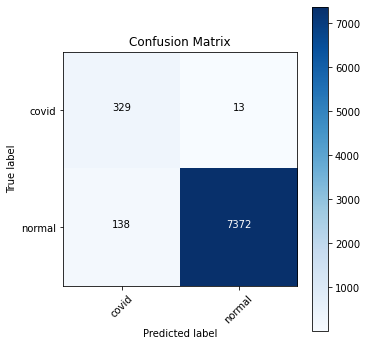

In [ ]:
# Print the Target names
target_names = []

for key in train_generator.class_indices:
    target_names.append(key)

# Confusion Matrix 
Y_pred = model.predict(test_generator)
y_pred = Y_pred > 0.5
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

# Print Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

In [ ]:
# predicate the two image we have with the model, and write the result
# load in the image
img = image.load_img('/content/13TUDO.tif',target_size=(300,300))

# create an array from it
img= image.img_to_array(img)
# normalization
img /= 255
img = np.expand_dims(img,axis=0)
preds = model.predict(img)
print(preds)

img = image.load_img('/content/5TUDO.tif',target_size=(300,300))

img= image.img_to_array(img)
img /= 255
img = np.expand_dims(img,axis=0)
preds = model.predict(img)
print(preds)